In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Make the data
series = np.sin((0.1*np.arange(400))**2)

This is time series of the form:<br>
$x(t)=np \cdot \sin \left(\omega t^2\right)$

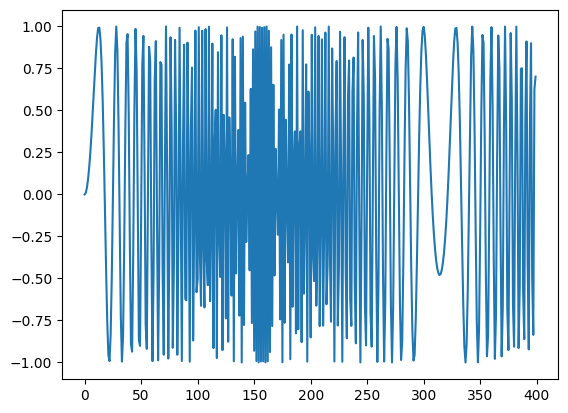

In [ ]:
# Plot the data
plt.plot(series)
plt.show()

### AR Linear model

In [ ]:
# Build the dataset
T = 10
D = 1
# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (390, 10) & Shape of Y : (390, 1)


In [ ]:
### Try AR linear model
model = nn.Linear(T, 1)

In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [ ]:
# Make train and test set

X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
## Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs = 200):

  # Stuffs to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    train_losses[it] = loss.item()

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}  Train Loss : {loss.item():4f}  Test Loss : {test_loss.item():4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,
                                  criterion,
                                  optimizer,
                                  X_train,
                                  y_train,
                                  X_test,
                                  y_test)

Epoch 5/200  Train Loss : 0.515132  Test Loss : 0.668296
Epoch 10/200  Train Loss : 0.512209  Test Loss : 0.645086
Epoch 15/200  Train Loss : 0.494168  Test Loss : 0.569086
Epoch 20/200  Train Loss : 0.494611  Test Loss : 0.579149
Epoch 25/200  Train Loss : 0.486952  Test Loss : 0.603220
Epoch 30/200  Train Loss : 0.485951  Test Loss : 0.602194
Epoch 35/200  Train Loss : 0.484214  Test Loss : 0.589342
Epoch 40/200  Train Loss : 0.484000  Test Loss : 0.579435
Epoch 45/200  Train Loss : 0.483846  Test Loss : 0.596751
Epoch 50/200  Train Loss : 0.483640  Test Loss : 0.594232
Epoch 55/200  Train Loss : 0.483500  Test Loss : 0.583971
Epoch 60/200  Train Loss : 0.483378  Test Loss : 0.590099
Epoch 65/200  Train Loss : 0.483384  Test Loss : 0.593183
Epoch 70/200  Train Loss : 0.483346  Test Loss : 0.587380
Epoch 75/200  Train Loss : 0.483347  Test Loss : 0.589750
Epoch 80/200  Train Loss : 0.483339  Test Loss : 0.590246
Epoch 85/200  Train Loss : 0.483326  Test Loss : 0.590092
Epoch 90/200  T

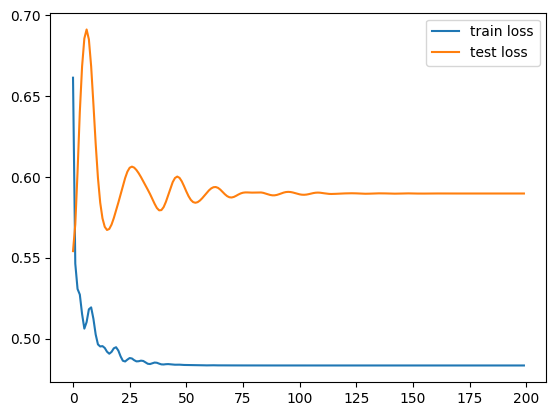

In [ ]:
# Plot train and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1,-1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

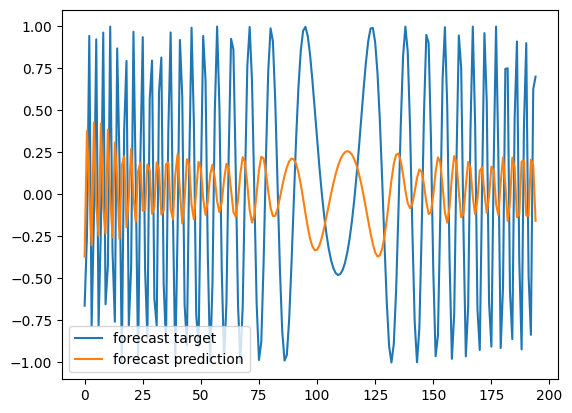

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1,-1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

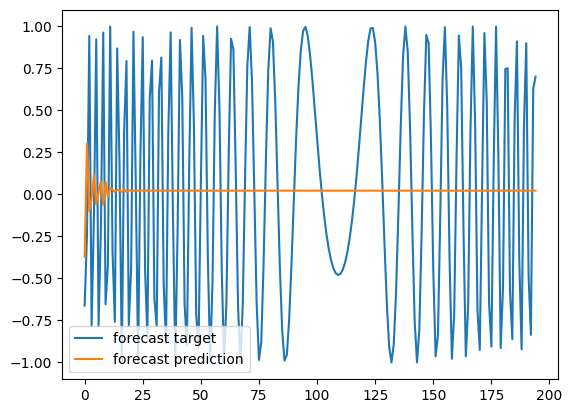

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

We can see that Linear model did a terrible terrible forecast.

### Using Simple RNN

In [ ]:
# Make the data
series = np.sin((0.1*np.arange(400))**2)

In [ ]:
# Build the dataset
T = 10
D = 1
# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (390, 10, 1) & Shape of Y : (390, 1)


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [ ]:
# mode data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.5013, Test Loss: 0.5064
Epoch  10/200, Train Loss: 0.4363, Test Loss: 0.5961
Epoch  15/200, Train Loss: 0.3780, Test Loss: 0.5191
Epoch  20/200, Train Loss: 0.3686, Test Loss: 0.5836
Epoch  25/200, Train Loss: 0.3515, Test Loss: 0.5740
Epoch  30/200, Train Loss: 0.3341, Test Loss: 0.5724
Epoch  35/200, Train Loss: 0.2938, Test Loss: 0.5032
Epoch  40/200, Train Loss: 0.2752, Test Loss: 0.4166
Epoch  45/200, Train Loss: 0.2453, Test Loss: 0.3711
Epoch  50/200, Train Loss: 0.1711, Test Loss: 0.3009
Epoch  55/200, Train Loss: 0.1415, Test Loss: 0.2655
Epoch  60/200, Train Loss: 0.1064, Test Loss: 0.2193
Epoch  65/200, Train Loss: 0.0750, Test Loss: 0.2510
Epoch  70/200, Train Loss: 0.0650, Test Loss: 0.1975
Epoch  75/200, Train Loss: 0.0555, Test Loss: 0.2032
Epoch  80/200, Train Loss: 0.0452, Test Loss: 0.2206
Epoch  85/200, Train Loss: 0.0323, Test Loss: 0.2191
Epoch  90/200, Train Loss: 0.0263, Test Loss: 0.2650
Epoch  95/200, Train Loss: 0.0206, Test Loss: 0

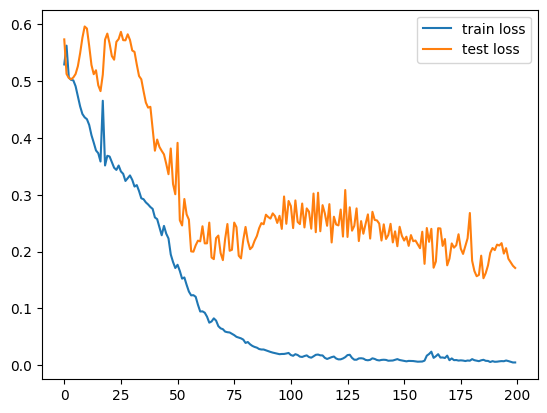

In [ ]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

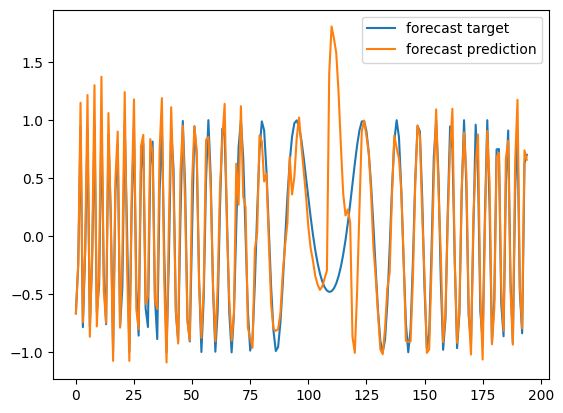

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

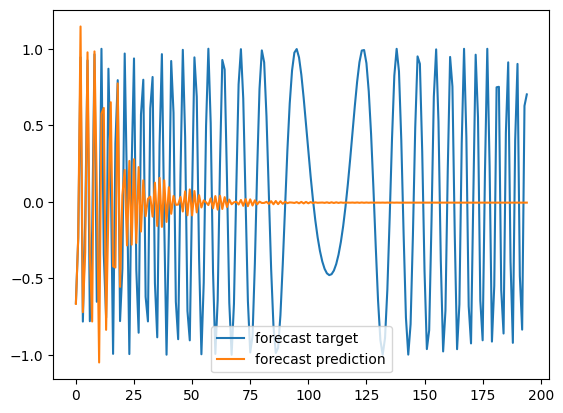

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Using LSTM

In [ ]:
# Make the data
series = np.sin((0.1*np.arange(400))**2)

In [ ]:
# Build the dataset
T = 10
D = 1
# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (390, 10, 1) & Shape of Y : (390, 1)


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
### Define simple RNN
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [ ]:
# mode data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.5121, Test Loss: 0.5608
Epoch  10/200, Train Loss: 0.5018, Test Loss: 0.6511
Epoch  15/200, Train Loss: 0.4827, Test Loss: 0.5748
Epoch  20/200, Train Loss: 0.4203, Test Loss: 0.5317
Epoch  25/200, Train Loss: 0.3368, Test Loss: 0.4009
Epoch  30/200, Train Loss: 0.1593, Test Loss: 0.1717
Epoch  35/200, Train Loss: 0.0453, Test Loss: 0.1092
Epoch  40/200, Train Loss: 0.0298, Test Loss: 0.0585
Epoch  45/200, Train Loss: 0.0180, Test Loss: 0.0365
Epoch  50/200, Train Loss: 0.0131, Test Loss: 0.0360
Epoch  55/200, Train Loss: 0.0102, Test Loss: 0.0298
Epoch  60/200, Train Loss: 0.0085, Test Loss: 0.0254
Epoch  65/200, Train Loss: 0.0067, Test Loss: 0.0262
Epoch  70/200, Train Loss: 0.0053, Test Loss: 0.0242
Epoch  75/200, Train Loss: 0.0046, Test Loss: 0.0231
Epoch  80/200, Train Loss: 0.0036, Test Loss: 0.0244
Epoch  85/200, Train Loss: 0.0030, Test Loss: 0.0238
Epoch  90/200, Train Loss: 0.0025, Test Loss: 0.0237
Epoch  95/200, Train Loss: 0.0021, Test Loss: 0

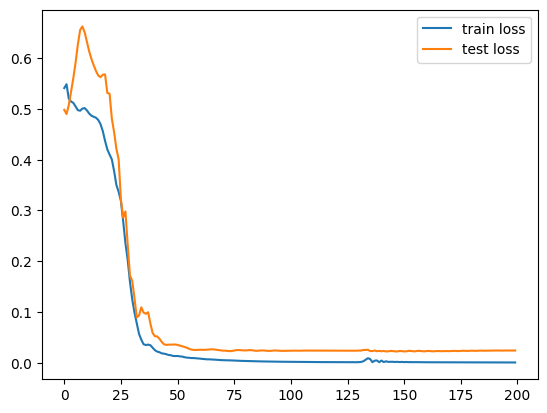

In [ ]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

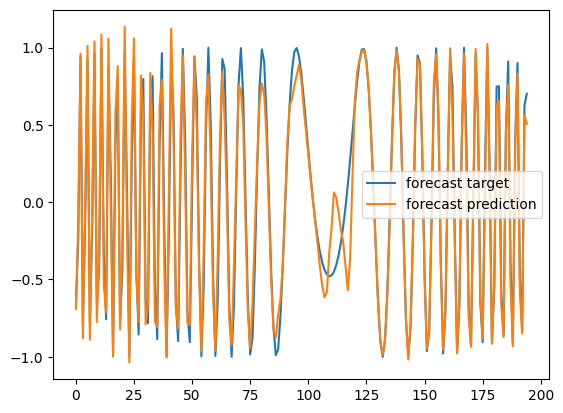

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

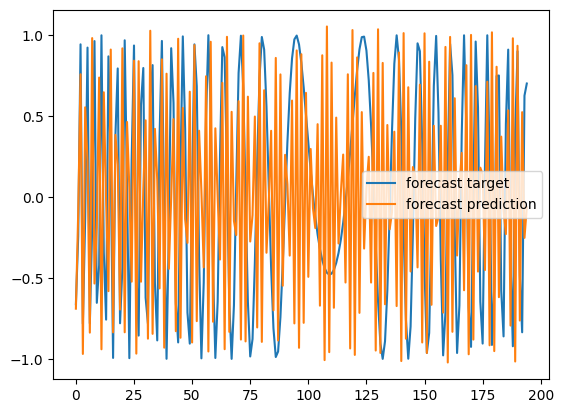

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Using GRU

In [ ]:
# Make the data
series = np.sin((0.1*np.arange(400))**2)

In [ ]:
# Build the dataset
T = 10
D = 1
# We want to see if we can use past 10 data to predict the new data
# Hence, T = 10

X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)

print(f"Shape of X : {X.shape} & Shape of Y : {Y.shape}")

Shape of X : (390, 10, 1) & Shape of Y : (390, 1)


In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
### Define simple RNN
class GRU(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(GRU, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.GRU(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Instantiate the model
model = GRU(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

GRU(
  (rnn): GRU(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [ ]:
# mode data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.5105, Test Loss: 0.5956
Epoch  10/200, Train Loss: 0.5026, Test Loss: 0.6606
Epoch  15/200, Train Loss: 0.4944, Test Loss: 0.5676
Epoch  20/200, Train Loss: 0.4867, Test Loss: 0.5964
Epoch  25/200, Train Loss: 0.4675, Test Loss: 0.5953
Epoch  30/200, Train Loss: 0.3903, Test Loss: 0.4471
Epoch  35/200, Train Loss: 0.2745, Test Loss: 0.2930
Epoch  40/200, Train Loss: 0.1214, Test Loss: 0.1660
Epoch  45/200, Train Loss: 0.0629, Test Loss: 0.0966
Epoch  50/200, Train Loss: 0.0345, Test Loss: 0.0881
Epoch  55/200, Train Loss: 0.0219, Test Loss: 0.0724
Epoch  60/200, Train Loss: 0.0168, Test Loss: 0.0709
Epoch  65/200, Train Loss: 0.0128, Test Loss: 0.0604
Epoch  70/200, Train Loss: 0.0089, Test Loss: 0.0521
Epoch  75/200, Train Loss: 0.0078, Test Loss: 0.0484
Epoch  80/200, Train Loss: 0.0060, Test Loss: 0.0454
Epoch  85/200, Train Loss: 0.0054, Test Loss: 0.0451
Epoch  90/200, Train Loss: 0.0045, Test Loss: 0.0424
Epoch  95/200, Train Loss: 0.0040, Test Loss: 0

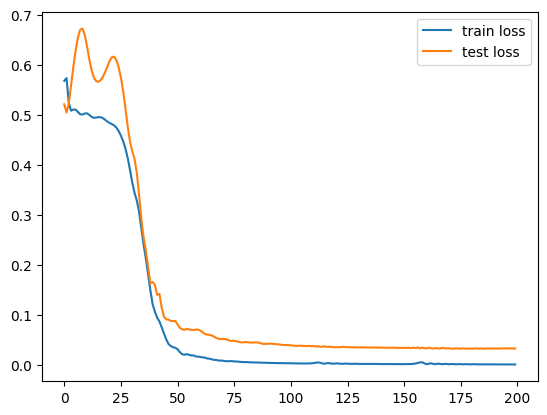

In [ ]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

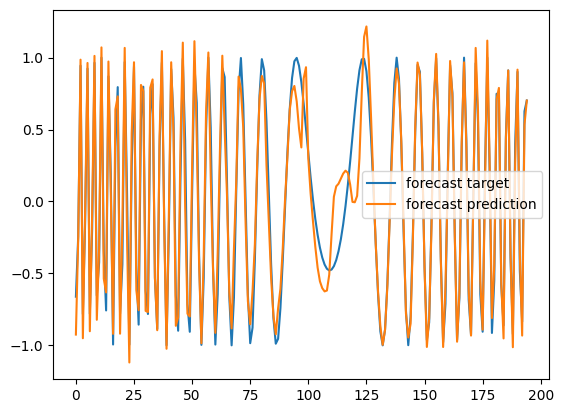

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# "correct forecast using true targets"

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

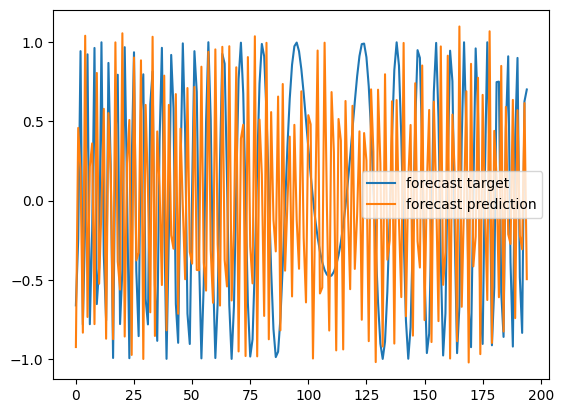

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

For this problem ,using LSTM or GRU has not made any difference.